In [1]:
%matplotlib inline  

In [2]:
import os
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [4]:
from Prior_optimization.gpr import GPR
from Prior_optimization import mean_functions, kernels
from Partial_stochasticity.Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Partial_stochasticity.Networks.mlp_masked import MLPMasked
from Samplers.likelihoods import LikCategorical
from Prior_optimization.priors import OptimGaussianPrior
from Utilities.rand_generators import ClassificationGenerator
from Utilities import util
from Partial_stochasticity.Networks.classification_net_masked import ClassificationNetMasked
from Full_stochasticity.Networks.classification_net import ClassificationNet
from Full_stochasticity.Networks.mlp import MLP
from Full_stochasticity.Networks.gaussian_reparam_mlp import GaussianMLPReparameterization
from Prior_optimization.wasserstein_mapper import MapperWasserstein
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper

In [5]:
util.set_seed(123)

In [6]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cpu 



# 1. Load `Banana` dataset

In [7]:
DATA_DIR = "./data/banana"
OUT_DIR_PS = "./exp/banana/partially_stochastic"

In [8]:
# Load banana dataset
X = np.loadtxt(os.path.join(
    DATA_DIR, "banana_X_train"), delimiter=",").astype(np.float32)
y = np.loadtxt(os.path.join(
    DATA_DIR, "banana_Y_train"), delimiter=",").reshape([-1]).astype(np.int64)

In [9]:
# Setup directories
ckpt_dir = os.path.join(OUT_DIR_PS, "ckpts")
figs_dir = os.path.join(OUT_DIR_PS, "figs")
util.ensure_dir(ckpt_dir)
util.ensure_dir(figs_dir)

# 2. Partially stochastic

Configure the neural network architecture. In this experiment, we use a 2-hidden layer MLP with tanh activation function. The number of hidden units at each layer is 100.

In [10]:
input_dim = 2
output_dim = 2
hidden_dims = [100] * 2
activation_fn = "tanh"

Configure the hyper-parameters of the prior optimization.  

In [11]:
# Configurations for the prior optimization
D = 3
mapper_batch_size = 256                                         # The factorization depth
prior_opt_configurations = {
    "n_data": mapper_batch_size,                                              # The batch size 
    "num_iters": 5000,                                          # The number of iterations of the prior optimization
    "output_dim": 2,                                            # The dimension of the output
    "lambd": (torch.tensor([0.25, 0.5])/D).to(device),          # The regularization parameters for the layers
    "n_samples": 100,                                           # The number of function samples
    "lr": 5e-2,                                                 # The learning rate for the optimizer
    "print_every": 100,                                         # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500                                      # After how many epochs a checkpoint should be saved
}

Setup of the values of the lengthsclaes and variances

In [12]:
variances = [1, 32]
lengthscales = [1, 4, 16]

Configure the hyper-parameters for the SGHMC sampler.  

In [13]:
# SGHMC Hyper-parameters
sampling_configs_ps = {
    "batch_size": 32,            # Mini-batch size
    "num_samples": 30,           # Total number of samples for each chain
    "n_discarded": 10,           # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,   # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,           # Thinning interval
    "lr": 0.01,                  # Step size
    "num_chains": 4,             # Number of chains
    "mdecay": 0.01,              # Momentum coefficient
    "print_every_n_samples": 5,  # After how many iterations an evaluation should be printed
    "lambd": 5e-8,               # The lambda for encouraging sparsity in the deterministic weights
    "train_det_before": 1250     # How many iterations the deterministic weights should be trained prior to sampling from the posterior
}

# 2.1 Optimize the prior

In [14]:
masks_list = []
for variance in variances:
    for lengthscale in lengthscales:
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))

        # Initialize data loader for the mapper
        data_loader = data_utils.DataLoader(
                            data_utils.TensorDataset(torch.from_numpy(X),
                                                     torch.from_numpy(y)),
                            batch_size=mapper_batch_size, shuffle=True)
        
        # Setup the measurement set generator
        # We draw measurement points from the training data
        rand_generator = ClassificationGenerator(data_loader)

        # Specify the target GP prior
        X_, y_ = rand_generator.get(return_label=True)
        kernel = kernels.Exponential(
            input_dim,
            lengthscales=torch.tensor([lengthscale], dtype=torch.double, device = device),
            variance=torch.tensor([variance], dtype=torch.double, device = device))
        gp = GPR(X_.reshape([mapper_batch_size, -1]).double(),
                            util.to_one_hot(y_, 2).double(),
                            kern=kernel, mean_function=mean_functions.Zero())
        # Initialize tunable MLP prior
        opt_bnn_sparse = FactorizedGaussianMLPReparameterization(input_dim=2, output_dim=2, D = D, activation_fn=activation_fn, 
            hidden_dims=hidden_dims, device = device)
        opt_bnn_sparse = opt_bnn_sparse.to(device)
        
        # Initialize the mapper
        saved_dir = os.path.join(OUT_DIR_PS, "len_{}_var_{}".format(
            lengthscale, variance))
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        mapper = PriorOptimisationMapper(out_dir=saved_dir, device=device, gp = gp).to(device)
        
        # Start optimization
        print("Start optimizing prior")
        p_hist, loss_hist = mapper.optimize(opt_bnn_sparse, rand_generator,**prior_opt_configurations)
        path = os.path.join(saved_dir, "loss_values.log")
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        np.savetxt(path, loss_hist, fmt='%.6e')
        path = os.path.join(saved_dir, "pruned_values.log")
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        np.savetxt(path, p_hist, fmt='%.6e')
        print("----" * 20)
        masks_list.append(opt_bnn_sparse.get_det_masks())
        with open(os.path.join(saved_dir, "masks_list.pkl"), "wb") as f:
            pickle.dump(masks_list, f)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Start optimizing prior
>>> Iteration #   1: Energy-Based Sliced Wasserstein Distance 25.4919 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy-Based Sliced Wasserstein Distance 15.0164 Number of pruned stochastic weights: 0
>>> Iteration # 200: Energy-Based Sliced Wasserstein Distance 14.8423 Number of pruned stochastic weights: 0
>>> Iteration # 300: Energy-Based Sliced Wasserstein Distance 14.6330 Number of pruned stochastic weights: 0
>>> Iteration # 400: Energy-Based Sliced Wasserstein Distance 14.9688 Number of pruned stochastic weights: 3
>>> Iteration # 500: Energy-Based Sliced Wasserstein Distance 16.7927 Number of pruned stochastic weights: 6
>>> Iteration # 600: Energy-Based Sliced Wasserstein Distance 15.2969 Number of pruned stochastic weights: 8
>>> Iteration # 700: Energy-Based Sliced Wasserstein Distance 15.4833 Number of pruned stochastic weights

## 2.1.1 Visualize Progression of the Prior Optimization

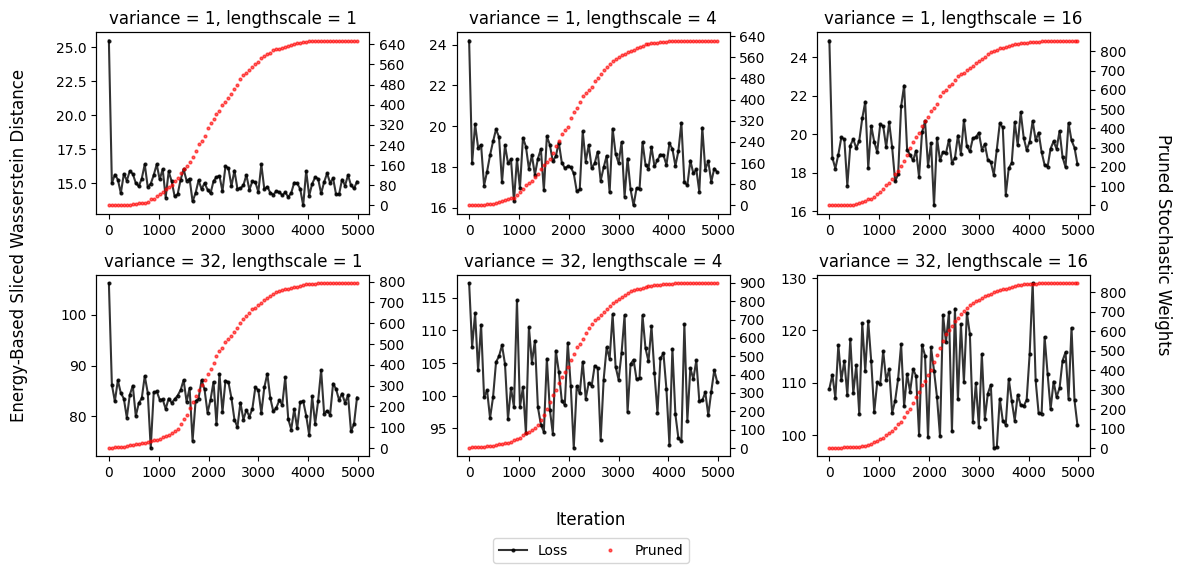

In [15]:
indices = np.arange(prior_opt_configurations["num_iters"])[::60]
fig, axs = plt.subplots(2, 3, figsize=(11, 5), sharex=False, dpi=100)

# For collecting legend handles/labels
all_handles = []
all_labels = []

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        sdist_file = os.path.join(OUT_DIR_PS, f"len_{lengthscale}_var_{variance}", "loss_values.log")
        sdist_vals = np.loadtxt(sdist_file)
        pruned_file = os.path.join(OUT_DIR_PS, f"len_{lengthscale}_var_{variance}", "pruned_values.log")
        pruned_vals = np.loadtxt(pruned_file)

        # Plot loss on primary axis
        h1, = axs[i, j].plot(indices, sdist_vals[indices], "-ok", ms=2, alpha=0.8, label="Loss")
        axs[i, j].set_title(rf"variance = {variance}, lengthscale = {lengthscale}")

        # Plot pruned weights on secondary y-axis
        ax2 = axs[i, j].twinx()
        h2, = ax2.plot(indices, pruned_vals[indices], "ro", ms=2, alpha=0.6, label="Pruned")
        ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        if i == 0 and j == 0:  # Only collect once (or use a set to avoid duplicates)
            all_handles.extend([h1, h2])
            all_labels.extend(["Loss", "Pruned"])

# Shared axis labels
fig.text(0.5, -0.05, "Iteration", ha="center", va="center", fontsize=12)
fig.text(-0.02, 0.5, "Energy-Based Sliced Wasserstein Distance", ha="center", va="center", rotation=90, fontsize=12)
fig.text(1.02, 0.5, "Pruned Stochastic Weights", ha="center", va="center", rotation=270, fontsize=12)

# Add legend outside the figure (bottom center)
fig.legend(all_handles, all_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.show()

# 2.2 Sample from posterior using SGHMC sampler

In [16]:
index = 0
for variance in variances:
    for lengthscale in lengthscales:
        # Load the mask
        saved_dir = os.path.join(OUT_DIR_PS, "len_{}_var_{}".format(
            lengthscale, variance))
        with open(os.path.join(saved_dir, "masks_list.pkl"), "rb") as f:
            masks_list = pickle.load(f)
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))
        
        data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampling_configs_ps["batch_size"], shuffle=True)
        weights_mask , bias_mask = masks_list[index]
        index+=1
        # Setup the likelihood
        net = MLPMasked(input_dim, output_dim, hidden_dims, activation_fn, weight_masks=weights_mask, bias_masks= bias_mask,
                task="classification", D= D, device = device)
        likelihood = LikCategorical()
        # Load the optimized prior
        ckpt_path = os.path.join(saved_dir, "ckpts", "ps-it-{}.ckpt".format(prior_opt_configurations["num_iters"]))
        print("Loading prior: {}".format(ckpt_path))
        prior = OptimGaussianPrior(ckpt_path)
        
        # Initialize the Bayesian net
        samples_dir = os.path.join(saved_dir, "samples")
        util.ensure_dir(samples_dir)
        bayes_net = ClassificationNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
        
        # Start sampling using SGHMC sampler
        bayes_net.sample_multi_chains(data_loader=data_loader, **sampling_configs_ps)
        mean_preds, preds = bayes_net.evaluate(data_loader, True, True)

        # Make predictions using the posterior
        preds = []
        pred_means = []
        targets = []
        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                pred_mean, pred = bayes_net.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

                pred_means.append(pred_mean)
                preds.append(pred)
                targets.append(target)

        pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
        preds = torch.cat(preds, dim=1).cpu().numpy()
        targets = torch.cat(targets, dim=0).cpu().numpy()
        x_grid = np.linspace(-3, 3, 40)
        xx, yy = np.meshgrid(x_grid, x_grid)
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T

        p, _ = bayes_net.predict(torch.from_numpy(Xplot).float(), True, True)
        p = p.cpu().numpy()
        
        # Save the predictions to file
        data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
        with open(os.path.join(saved_dir, "preds.pickle"), 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print("----" * 20)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Loading prior: ./exp/banana/partially_stochastic/len_1_var_1/ckpts/ps-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.11721 Acc = 0.9375 
 Pruned deterministic weights: 2 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.10717 Acc = 0.9688 
 Pruned deterministic weights: 2 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.13958 Acc = 0.9688 
 Pruned deterministic weights: 2 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.15774 Acc = 0.9375 
 Pruned deterministic weights: 2 Pruned stochastic weights: 0
Chain: 2
Samples #    25 : NLL = 0.05977 Acc = 1.0000 
 Pruned deterministic weights: 42 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.11177 Acc = 0.9375 
 Pruned deterministic weights: 42 Pruned stochastic weights: 0
Samples #    35 : NLL = 0.09208 Acc = 0.9688 
 Pruned deterministic weights: 42 Pruned stochastic weights: 0
Samples #    40 : NLL = 0.21364

80it [00:00, 112.36it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 1
Loading prior: ./exp/banana/partially_stochastic/len_4_var_1/ckpts/ps-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.08513 Acc = 1.0000 
 Pruned deterministic weights: 7 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.04993 Acc = 0.9688 
 Pruned deterministic weights: 7 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.14770 Acc = 0.9375 
 Pruned deterministic weights: 7 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.09093 Acc = 0.9688 
 Pruned deterministic weights: 7 Pruned stochastic weights: 0
Chain: 2
Samples #    25 : NLL = 0.15386 Acc = 0.9375 
 Pruned deterministic weights: 56 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.21029 Acc = 0.9062 
 Pruned deterministic weights: 56 Pruned stochastic weights: 0
Samples #    35 : NLL = 0.18071 Acc = 0.9688 
 Pruned deter

80it [00:00, 114.03it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 1
Loading prior: ./exp/banana/partially_stochastic/len_16_var_1/ckpts/ps-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.16618 Acc = 0.9375 
 Pruned deterministic weights: 5 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.08516 Acc = 0.9688 
 Pruned deterministic weights: 5 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.11898 Acc = 0.9062 
 Pruned deterministic weights: 5 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.18887 Acc = 0.8750 
 Pruned deterministic weights: 5 Pruned stochastic weights: 0
Chain: 2
Samples #    25 : NLL = 0.08273 Acc = 0.9688 
 Pruned deterministic weights: 47 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.08116 Acc = 1.0000 
 Pruned deterministic weights: 47 Pruned stochastic weights: 0
Samples #    35 : NLL = 0.09970 Acc = 0.9688 
 Pruned det

80it [00:00, 97.07it/s] 


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 32
Loading prior: ./exp/banana/partially_stochastic/len_1_var_32/ckpts/ps-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.18077 Acc = 0.9375 
 Pruned deterministic weights: 2 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.13056 Acc = 0.9375 
 Pruned deterministic weights: 2 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.19328 Acc = 0.9375 
 Pruned deterministic weights: 2 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.19120 Acc = 0.9375 
 Pruned deterministic weights: 2 Pruned stochastic weights: 0
Chain: 2
Samples #    25 : NLL = 0.12150 Acc = 0.9375 
 Pruned deterministic weights: 55 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.22455 Acc = 0.8750 
 Pruned deterministic weights: 55 Pruned stochastic weights: 0
Samples #    35 : NLL = 0.09343 Acc = 0.9688 
 Pruned det

80it [00:00, 111.72it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 32
Loading prior: ./exp/banana/partially_stochastic/len_4_var_32/ckpts/ps-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.16794 Acc = 0.9375 
 Pruned deterministic weights: 5 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.19076 Acc = 0.9062 
 Pruned deterministic weights: 5 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.16556 Acc = 0.9062 
 Pruned deterministic weights: 5 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.14975 Acc = 0.9375 
 Pruned deterministic weights: 5 Pruned stochastic weights: 0
Chain: 2
Samples #    25 : NLL = 0.13633 Acc = 0.9688 
 Pruned deterministic weights: 40 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.28609 Acc = 0.8750 
 Pruned deterministic weights: 40 Pruned stochastic weights: 0
Samples #    35 : NLL = 0.22079 Acc = 0.9375 
 Pruned det

80it [00:00, 110.84it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 32
Loading prior: ./exp/banana/partially_stochastic/len_16_var_32/ckpts/ps-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.09544 Acc = 0.9688 
 Pruned deterministic weights: 3 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.14164 Acc = 0.9688 
 Pruned deterministic weights: 3 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.13383 Acc = 0.9375 
 Pruned deterministic weights: 3 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.08902 Acc = 1.0000 
 Pruned deterministic weights: 3 Pruned stochastic weights: 0
Chain: 2
Samples #    25 : NLL = 0.08721 Acc = 1.0000 
 Pruned deterministic weights: 50 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.11153 Acc = 0.9688 
 Pruned deterministic weights: 50 Pruned stochastic weights: 0
Samples #    35 : NLL = 0.08616 Acc = 1.0000 
 Pruned d

80it [00:00, 111.28it/s]


--------------------------------------------------------------------------------


# 2.3. Visualize predictive posterior

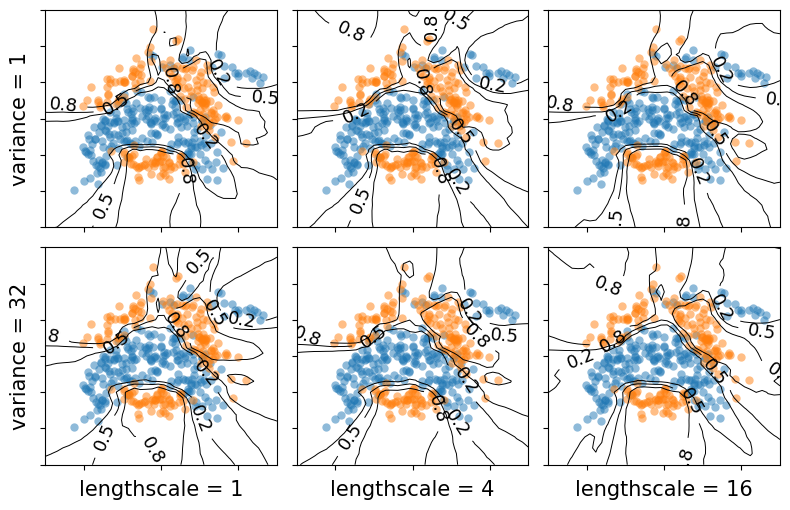

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, tight_layout=False,
                        figsize=(8, 5.2), sharex=True, sharey=True, dpi=100)

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        data_file = os.path.join(OUT_DIR_PS, "len_{}_var_{}".format(lengthscale, variance),
                                  "preds.pickle")
        
        with open(data_file, "rb") as f:
            data = pickle.load(f)
        
        X = data['X']
        y = data['y']
        p = data['p']
        xx = data['xx']
        yy = data['yy']

        mask = y.reshape([-1, 1])[:, 0] == 1
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T
        
        ax[i, j].plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5, ms=6)
        ax[i, j].plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5, ms=6)
        CS = ax[i, j].contour(
            xx,
            yy,
            p[:, 0].reshape(*xx.shape),
            [0.2, 0.5, 0.8],
            colors="k",
            linewidths=0.7,
            zorder=100,
        )
        ax[i, j].clabel(CS, inline=1, fontsize=13, fmt='%1.1f')
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        
        if j == 0:
            ax[i, j].set_ylabel(r"variance = {}".format(variance), fontsize=15)
        if i == 1:
            ax[i, j].set_xlabel(r"lengthscale = {}".format(lengthscale), fontsize=15)
            
plt.tight_layout()
plt.show()

# 3. Fully stochastic

Set up the output directory

In [18]:
OUT_DIR_FS = "./exp/banana/fully_stochastic"

Configure the hyperparameters

In [19]:
mapper_n_samples = 128         # The size of mini batch used in Wasserstein optimization
mapper_n_lipschitz_iters = 200 # The number of Lipschitz function iterations per prior iteration
mapper_n_prior_iters = 200     # The number of prior iterations
mapper_lipschitz_lr = 0.02     # The learning rate for the opimization of the Lipschitz function (inner loop)
mapper_prior_lr = 0.05         # The learning rate for the optimization of the prior (outer loop)

In [20]:
sampler_batch_size = 32
sampling_configs = {
    "batch_size": sampler_batch_size, # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

## 3.1 Optimize the prior

In [21]:
for variance in variances:
    for lengthscale in lengthscales:
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))

        # Initialize data loader for the mapper
        data_loader = data_utils.DataLoader(
                            data_utils.TensorDataset(torch.from_numpy(X),
                                                     torch.from_numpy(y)),
                            batch_size=mapper_batch_size, shuffle=True)
        
        # Setup the measurement set generator
        # We draw measurement points from the training data
        rand_generator = ClassificationGenerator(data_loader)

        # Specify the target GP prior
        X_, y_ = rand_generator.get(return_label=True)
        kernel = kernels.RBF(
            input_dim,
            lengthscales=torch.tensor([lengthscale], dtype=torch.double),
            variance=torch.tensor([variance], dtype=torch.double))
        gp = GPR(X_.reshape([mapper_batch_size, -1]).double(),
                            util.to_one_hot(y_).double(),
                            kern=kernel, mean_function=mean_functions.Zero())

        # Initialize tunable MLP prior
        mlp_reparam = GaussianMLPReparameterization(input_dim, output_dim,
            hidden_dims, activation_fn, scaled_variance=True)
        
        # Initialize the mapper
        saved_dir = os.path.join(OUT_DIR_FS, "len_{}_var_{}".format(
            lengthscale, variance))
        mapper = MapperWasserstein(gp, mlp_reparam, rand_generator, out_dir=saved_dir,
                                   output_dim=output_dim,
                                   n_data=mapper_batch_size,
                                   wasserstein_steps=(0, mapper_n_lipschitz_iters),
                                   wasserstein_lr=mapper_lipschitz_lr,
                                   wasserstein_thres=0.1,
                                   n_gpu=1)
        
        # Start optimization
        print("Start optimizing prior")
        w_hist = mapper.optimize(num_iters=mapper_n_prior_iters, n_samples=mapper_n_samples,
                        lr=mapper_prior_lr, print_every=5,
                        save_ckpt_every=20, debug=True)
        path = os.path.join(saved_dir, "wsr_values.log")
        np.savetxt(path, w_hist, fmt='%.6e')
        print("----" * 20)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Start optimizing prior
>>> Iteration #   1: Wasserstein Dist 66.5050
>>> Iteration #   5: Wasserstein Dist 17.9444
>>> Iteration #  10: Wasserstein Dist 10.1347
>>> Iteration #  15: Wasserstein Dist 10.0852
>>> Iteration #  20: Wasserstein Dist 10.2526
>>> Iteration #  25: Wasserstein Dist 7.5443
>>> Iteration #  30: Wasserstein Dist 7.6941
>>> Iteration #  35: Wasserstein Dist 7.3190
>>> Iteration #  40: Wasserstein Dist 7.3247
>>> Iteration #  45: Wasserstein Dist 6.8523
>>> Iteration #  50: Wasserstein Dist 8.7098
>>> Iteration #  55: Wasserstein Dist 6.6342
>>> Iteration #  60: Wasserstein Dist 4.7771
>>> Iteration #  65: Wasserstein Dist 6.6425
>>> Iteration #  70: Wasserstein Dist 6.7894
>>> Iteration #  75: Wasserstein Dist 5.1672
>>> Iteration #  80: Wasserstein Dist 7.8628
>>> Iteration #  85: Wasserstein Dist 5.7222
>>> Iteration #  90: Wasserstein Dist 4.8771
>>> Iter

## 3.1.1 Show the progress of the prior optimization

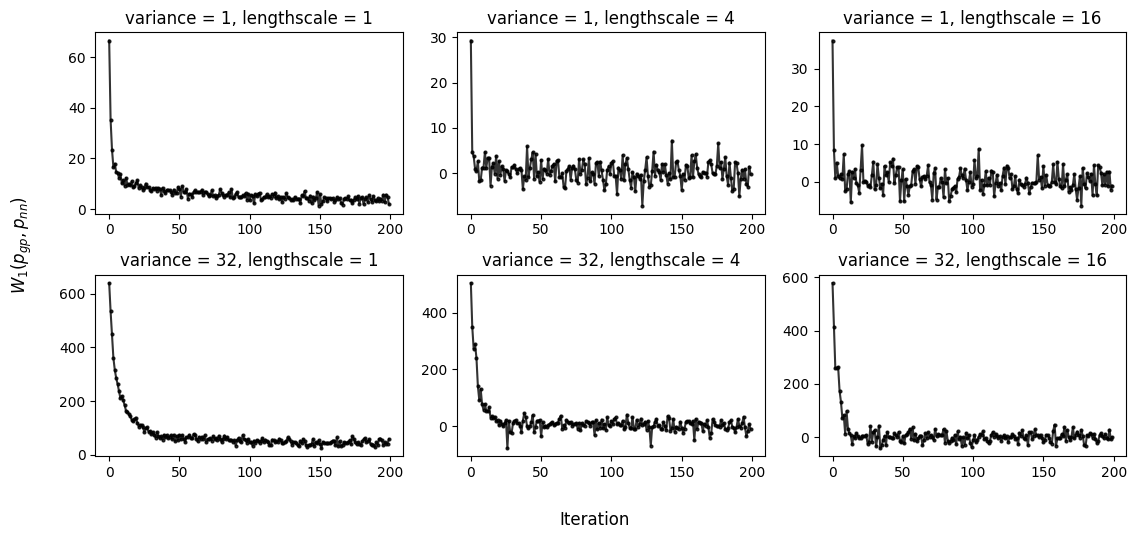

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(11, 5), sharex=False, dpi=100)

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        wdist_file = os.path.join(OUT_DIR_FS, "len_{}_var_{}".format(lengthscale, variance),
                                  "wsr_values.log")
        wdist_vals = np.loadtxt(wdist_file)
        
        axs[i, j].plot(wdist_vals, "-ok", ms=2, alpha=0.8)
        axs[i, j].set_title(r"variance = {}, lengthscale = {}".format(variance, lengthscale))


fig.text(0.5, -0.05, "Iteration", ha="center", va="center", fontsize=12)
fig.text(-0.02, 0.5, r"$W_1(p_{gp}, p_{nn})$", ha="center", va="center", rotation=90, fontsize=12)
        
plt.tight_layout()
plt.show()

## 3.2 Posterior Inference

In [23]:
	
for variance in variances:
    for lengthscale in lengthscales:
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))
        
        data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        
        # Setup the likelihood
        net = MLP(input_dim, output_dim, hidden_dims, activation_fn,
                task="classification")
        likelihood = LikCategorical()
        
        # Load the optimized prior
        saved_dir = os.path.join(OUT_DIR_FS, "len_{}_var_{}".format(
            lengthscale, variance))
        ckpt_path = os.path.join(saved_dir, "ckpts", "it-{}.ckpt".format(mapper_n_prior_iters))
        print("Loading prior: {}".format(ckpt_path))
        prior = OptimGaussianPrior(ckpt_path)
        
        # Initialize the Bayesian net
        samples_dir = os.path.join(saved_dir, "samples")
        util.ensure_dir(samples_dir)
        bayes_net = ClassificationNet(net, likelihood, prior, saved_dir, n_gpu=0)
        
        # Start sampling using SGHMC sampler
        bayes_net.sample_multi_chains(data_loader=data_loader, **sampling_configs)
        mean_preds, preds = bayes_net.evaluate(data_loader, True, True)

        # Make predictions using the posterior
        preds = []
        pred_means = []
        targets = []
        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                pred_mean, pred = bayes_net.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

                pred_means.append(pred_mean)
                preds.append(pred)
                targets.append(target)

        pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
        preds = torch.cat(preds, dim=1).cpu().numpy()
        targets = torch.cat(targets, dim=0).cpu().numpy()
        x_grid = np.linspace(-3, 3, 40)
        xx, yy = np.meshgrid(x_grid, x_grid)
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T

        p, _ = bayes_net.predict(torch.from_numpy(Xplot).float(), True, True)
        p = p.cpu().numpy()
        
        # Save the predictions to file
        data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
        with open(os.path.join(saved_dir, "preds.pickle"), 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print("----" * 20)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Loading prior: ./exp/banana/fully_stochastic/len_1_var_1/ckpts/it-200.ckpt
Chain: 0
Samples #     5 : NLL = 0.29458 Acc = 0.9062 
Samples #    10 : NLL = 0.31714 Acc = 0.9375 
Samples #    15 : NLL = 0.23290 Acc = 0.9375 
Samples #    20 : NLL = 0.19530 Acc = 0.9375 
Samples #    25 : NLL = 0.28468 Acc = 0.8750 
Samples #    30 : NLL = 0.30287 Acc = 0.8750 
Chain: 1
Samples #    35 : NLL = 0.30834 Acc = 0.8125 
Samples #    40 : NLL = 0.24447 Acc = 0.9062 
Samples #    45 : NLL = 0.22392 Acc = 0.9688 
Samples #    50 : NLL = 0.16106 Acc = 1.0000 
Samples #    55 : NLL = 0.25401 Acc = 0.9062 
Samples #    60 : NLL = 0.24155 Acc = 0.9062 
Chain: 2
Samples #    65 : NLL = 0.25935 Acc = 0.9375 
Samples #    70 : NLL = 0.27521 Acc = 0.8750 
Samples #    75 : NLL = 0.28426 Acc = 0.9062 
Samples #    80 : NLL = 0.19770 Acc = 1.0000 
Samples #    85 : NLL = 0.36960 Acc = 0.8125 
Samples

120it [00:00, 144.67it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 1
Loading prior: ./exp/banana/fully_stochastic/len_4_var_1/ckpts/it-200.ckpt
Chain: 0
Samples #     5 : NLL = 0.44820 Acc = 0.8438 
Samples #    10 : NLL = 0.39793 Acc = 0.9375 
Samples #    15 : NLL = 0.46548 Acc = 0.8125 
Samples #    20 : NLL = 0.48262 Acc = 0.7500 
Samples #    25 : NLL = 0.52959 Acc = 0.7812 
Samples #    30 : NLL = 0.46465 Acc = 0.8438 
Chain: 1
Samples #    35 : NLL = 0.47349 Acc = 0.7500 
Samples #    40 : NLL = 0.63272 Acc = 0.7188 
Samples #    45 : NLL = 0.48995 Acc = 0.8125 
Samples #    50 : NLL = 0.52882 Acc = 0.7500 
Samples #    55 : NLL = 0.45635 Acc = 0.8750 
Samples #    60 : NLL = 0.47980 Acc = 0.7812 
Chain: 2
Samples #    65 : NLL = 0.44893 Acc = 0.8438 
Samples #    70 : NLL = 0.43422 Acc = 0.9062 
Samples #    75 : NLL = 0.45109 Acc = 0.8750 
Samples #    80 : 

120it [00:00, 144.06it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 1
Loading prior: ./exp/banana/fully_stochastic/len_16_var_1/ckpts/it-200.ckpt
Chain: 0
Samples #     5 : NLL = 0.65093 Acc = 0.7188 
Samples #    10 : NLL = 0.71658 Acc = 0.5312 
Samples #    15 : NLL = 0.65353 Acc = 0.7812 
Samples #    20 : NLL = 0.67367 Acc = 0.6875 
Samples #    25 : NLL = 0.67703 Acc = 0.7188 
Samples #    30 : NLL = 0.67765 Acc = 0.6875 
Chain: 1
Samples #    35 : NLL = 0.66104 Acc = 0.7812 
Samples #    40 : NLL = 0.68473 Acc = 0.5938 
Samples #    45 : NLL = 0.64823 Acc = 0.8125 
Samples #    50 : NLL = 0.65311 Acc = 0.6250 
Samples #    55 : NLL = 0.64736 Acc = 0.6562 
Samples #    60 : NLL = 0.67213 Acc = 0.6875 
Chain: 2
Samples #    65 : NLL = 0.70990 Acc = 0.5938 
Samples #    70 : NLL = 0.66843 Acc = 0.7500 
Samples #    75 : NLL = 0.67501 Acc = 0.6250 
Samples #    80 

120it [00:00, 146.88it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 32
Loading prior: ./exp/banana/fully_stochastic/len_1_var_32/ckpts/it-200.ckpt
Chain: 0
Samples #     5 : NLL = 0.16930 Acc = 0.9375 
Samples #    10 : NLL = 0.19547 Acc = 0.9062 
Samples #    15 : NLL = 0.16898 Acc = 0.9375 
Samples #    20 : NLL = 0.23329 Acc = 0.8750 
Samples #    25 : NLL = 0.14407 Acc = 0.9688 
Samples #    30 : NLL = 0.09436 Acc = 1.0000 
Chain: 1
Samples #    35 : NLL = 0.07848 Acc = 1.0000 
Samples #    40 : NLL = 0.23949 Acc = 0.9062 
Samples #    45 : NLL = 0.12545 Acc = 0.9688 
Samples #    50 : NLL = 0.18172 Acc = 1.0000 
Samples #    55 : NLL = 0.06776 Acc = 1.0000 
Samples #    60 : NLL = 0.17602 Acc = 0.9375 
Chain: 2
Samples #    65 : NLL = 0.17410 Acc = 0.9375 
Samples #    70 : NLL = 0.18441 Acc = 0.9375 
Samples #    75 : NLL = 0.12694 Acc = 0.9375 
Samples #    80 

120it [16:41,  8.35s/it]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 32
Loading prior: ./exp/banana/fully_stochastic/len_4_var_32/ckpts/it-200.ckpt
Chain: 0
Samples #     5 : NLL = 0.25095 Acc = 0.8750 
Samples #    10 : NLL = 0.28808 Acc = 0.9062 
Samples #    15 : NLL = 0.16886 Acc = 0.9688 
Samples #    20 : NLL = 0.25015 Acc = 0.8750 
Samples #    25 : NLL = 0.21786 Acc = 1.0000 
Samples #    30 : NLL = 0.22953 Acc = 0.8750 
Chain: 1
Samples #    35 : NLL = 0.25314 Acc = 0.9062 
Samples #    40 : NLL = 0.34873 Acc = 0.9062 
Samples #    45 : NLL = 0.27193 Acc = 0.9062 
Samples #    50 : NLL = 0.38305 Acc = 0.7500 
Samples #    55 : NLL = 0.31175 Acc = 0.8438 
Samples #    60 : NLL = 0.22459 Acc = 0.9062 
Chain: 2
Samples #    65 : NLL = 0.26199 Acc = 0.8438 
Samples #    70 : NLL = 0.30701 Acc = 0.8125 
Samples #    75 : NLL = 0.36859 Acc = 0.7812 
Samples #    80 

120it [00:00, 134.16it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 32
Loading prior: ./exp/banana/fully_stochastic/len_16_var_32/ckpts/it-200.ckpt
Chain: 0
Samples #     5 : NLL = 0.53033 Acc = 0.7812 
Samples #    10 : NLL = 0.43891 Acc = 0.8438 
Samples #    15 : NLL = 0.43682 Acc = 0.8750 
Samples #    20 : NLL = 0.38811 Acc = 0.9375 
Samples #    25 : NLL = 0.49505 Acc = 0.7812 
Samples #    30 : NLL = 0.41143 Acc = 0.8750 
Chain: 1
Samples #    35 : NLL = 0.45777 Acc = 0.7812 
Samples #    40 : NLL = 0.53976 Acc = 0.8438 
Samples #    45 : NLL = 0.47880 Acc = 0.8438 
Samples #    50 : NLL = 0.50248 Acc = 0.7500 
Samples #    55 : NLL = 0.47498 Acc = 0.8750 
Samples #    60 : NLL = 0.46960 Acc = 0.8750 
Chain: 2
Samples #    65 : NLL = 0.63633 Acc = 0.5625 
Samples #    70 : NLL = 0.65375 Acc = 0.5938 
Samples #    75 : NLL = 0.59456 Acc = 0.8438 
Samples #    8

120it [00:00, 164.71it/s]


--------------------------------------------------------------------------------


## 3.3 Visualize the predictive posterior

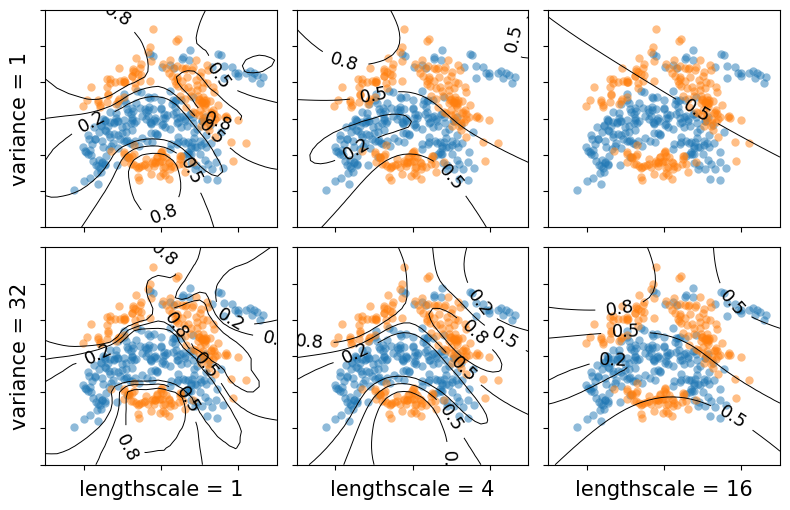

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, tight_layout=False,
                        figsize=(8, 5.2), sharex=True, sharey=True, dpi=100)

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        data_file = os.path.join(OUT_DIR_FS, "len_{}_var_{}".format(lengthscale, variance),
                                  "preds.pickle")
        
        with open(data_file, "rb") as f:
            data = pickle.load(f)
        
        X = data['X']
        y = data['y']
        p = data['p']
        xx = data['xx']
        yy = data['yy']

        mask = y.reshape([-1, 1])[:, 0] == 1
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T
        
        ax[i, j].plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5, ms=6)
        ax[i, j].plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5, ms=6)
        CS = ax[i, j].contour(
            xx,
            yy,
            p[:, 0].reshape(*xx.shape),
            [0.2, 0.5, 0.8],
            colors="k",
            linewidths=0.7,
            zorder=100,
        )
        ax[i, j].clabel(CS, inline=1, fontsize=13, fmt='%1.1f')
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        
        if j == 0:
            ax[i, j].set_ylabel(r"variance = {}".format(variance), fontsize=15)
        if i == 1:
            ax[i, j].set_xlabel(r"lengthscale = {}".format(lengthscale), fontsize=15)
            
plt.tight_layout()
plt.show()